In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
from geopy.distance import geodesic

# Set seed for reproducibility
np.random.seed(42)

# Number of synthetic samples
n_samples = 10000

# NYC approximate coordinate ranges
pickup_lat_range = (40.60, 40.90)
pickup_lon_range = (-74.05, -73.75)
dropoff_lat_range = (40.60, 40.90)
dropoff_lon_range = (-74.05, -73.75)

# Generate random pickup datetimes
start_date = datetime(2023, 1, 1)
pickup_datetimes = [start_date + timedelta(minutes=np.random.randint(0, 525600)) for _ in range(n_samples)]

# Generate coordinates
pickup_latitudes = np.random.uniform(*pickup_lat_range, n_samples)
pickup_longitudes = np.random.uniform(*pickup_lon_range, n_samples)
dropoff_latitudes = np.random.uniform(*dropoff_lat_range, n_samples)
dropoff_longitudes = np.random.uniform(*dropoff_lon_range, n_samples)

# Passenger counts between 1 and 6
passenger_counts = np.random.randint(1, 7, n_samples)

# Compute distances (in km)
distances = [
    geodesic((pickup_latitudes[i], pickup_longitudes[i]), (dropoff_latitudes[i], dropoff_longitudes[i])).km
    for i in range(n_samples)
]

# Generate fare amount based on distance + randomness + base fare
base_fare = 2.5  # base flag drop
fare_amounts = [
    round(base_fare + dist * np.random.uniform(1.5, 2.5) + np.random.normal(0, 2), 2)
    for dist in distances
]

# Construct DataFrame
df_synthetic = pd.DataFrame({
    'pickup_datetime': pickup_datetimes,
    'pickup_longitude': pickup_longitudes,
    'pickup_latitude': pickup_latitudes,
    'dropoff_longitude': dropoff_longitudes,
    'dropoff_latitude': dropoff_latitudes,
    'passenger_count': passenger_counts,
    'fare_amount': fare_amounts
})

# Display first few rows
print(df_synthetic.head())

# Save to CSV
df_synthetic.to_csv('/content/synthetic_taxi_fare.csv', index=False)
print("✅ Synthetic dataset saved as /content/synthetic_taxi_fare.csv")


      pickup_datetime  pickup_longitude  pickup_latitude  dropoff_longitude  \
0 2023-03-26 16:38:00        -73.963085        40.618928         -73.933489   
1 2023-04-02 14:52:00        -73.939177        40.632357         -73.826636   
2 2023-09-12 01:18:00        -73.880690        40.795075         -73.838565   
3 2023-06-29 23:38:00        -73.766780        40.693746         -73.989477   
4 2023-03-18 13:48:00        -73.765644        40.704409         -73.944801   

   dropoff_latitude  passenger_count  fare_amount  
0         40.748698                5        38.83  
1         40.881369                6        60.14  
2         40.870642                3        20.41  
3         40.896414                6        56.75  
4         40.858580                4        54.50  
✅ Synthetic dataset saved as /content/synthetic_taxi_fare.csv


In [2]:
import pandas as pd
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split

# Load the synthetic dataset
df = pd.read_csv('/content/synthetic_taxi_fare.csv', parse_dates=['pickup_datetime'])

# ✅ Feature Engineering

# Extract datetime features
df['hour'] = df['pickup_datetime'].dt.hour
df['day'] = df['pickup_datetime'].dt.day
df['month'] = df['pickup_datetime'].dt.month
df['weekday'] = df['pickup_datetime'].dt.weekday

# Calculate geodesic distance again as a feature
df['distance_km'] = df.apply(lambda row: geodesic(
    (row['pickup_latitude'], row['pickup_longitude']),
    (row['dropoff_latitude'], row['dropoff_longitude'])
).km, axis=1)

# Drop original datetime (optional for Random Forest)
df.drop(columns=['pickup_datetime'], inplace=True)

# Sanity check
print(df.head())
print("\n✅ Feature engineering complete. Dataset is ready for model training.")


   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.963085        40.618928         -73.933489         40.748698   
1        -73.939177        40.632357         -73.826636         40.881369   
2        -73.880690        40.795075         -73.838565         40.870642   
3        -73.766780        40.693746         -73.989477         40.896414   
4        -73.765644        40.704409         -73.944801         40.858580   

   passenger_count  fare_amount  hour  day  month  weekday  distance_km  
0                5        38.83    16   26      3        6    14.626183  
1                6        60.14    14    2      4        6    29.240019  
2                3        20.41     1   12      9        1     9.112918  
3                6        56.75    23   29      6        3    29.321704  
4                4        54.50    13   18      3        5    22.843439  

✅ Feature engineering complete. Dataset is ready for model training.


In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pickle

# Define features and target
features = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
            'passenger_count', 'hour', 'day', 'month', 'weekday', 'distance_km']
target = 'fare_amount'

X = df[features]
y = df[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"✅ Model trained successfully!")
print(f"MAE: ${mae:.2f}")
print(f"RMSE: ${rmse:.2f}")

# Save model with pickle
with open('/content/random_forest_taxi_model.pkl', 'wb') as f:
    pickle.dump(model, f)
print("✅ Model saved to /content/random_forest_taxi_model.pkl")


✅ Model trained successfully!
MAE: $4.18
RMSE: $5.35
✅ Model saved to /content/random_forest_taxi_model.pkl


R² Score: 0.8854


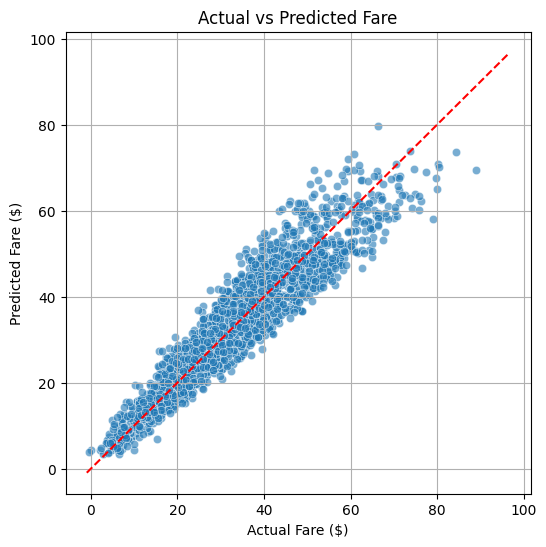

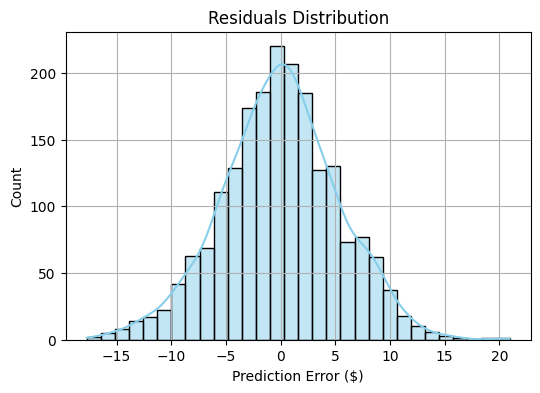

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

# Compute residuals
residuals = y_test - y_pred

# R² Score
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")

# 1. Actual vs Predicted
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.xlabel("Actual Fare ($)")
plt.ylabel("Predicted Fare ($)")
plt.title("Actual vs Predicted Fare")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.grid()
plt.show()

# 2. Residual Distribution
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True, bins=30, color="skyblue")
plt.title("Residuals Distribution")
plt.xlabel("Prediction Error ($)")
plt.grid()
plt.show()


In [5]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from geopy.distance import geodesic
import pickle

# Load the trained model
with open('/content/random_forest_taxi_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Generate 30 new synthetic trips
n_future = 30
now = datetime.now()

pickup_lat_range = (40.60, 40.90)
pickup_lon_range = (-74.05, -73.75)
dropoff_lat_range = (40.60, 40.90)
dropoff_lon_range = (-74.05, -73.75)

pickup_times = [now + timedelta(minutes=np.random.randint(0, 1440)) for _ in range(n_future)]
pickup_lat = np.random.uniform(*pickup_lat_range, n_future)
pickup_lon = np.random.uniform(*pickup_lon_range, n_future)
dropoff_lat = np.random.uniform(*dropoff_lat_range, n_future)
dropoff_lon = np.random.uniform(*dropoff_lon_range, n_future)
passenger_count = np.random.randint(1, 7, n_future)

# Build future DataFrame
future_df = pd.DataFrame({
    'pickup_datetime': pickup_times,
    'pickup_longitude': pickup_lon,
    'pickup_latitude': pickup_lat,
    'dropoff_longitude': dropoff_lon,
    'dropoff_latitude': dropoff_lat,
    'passenger_count': passenger_count
})

# Feature engineering for predictions
future_df['hour'] = future_df['pickup_datetime'].dt.hour
future_df['day'] = future_df['pickup_datetime'].dt.day
future_df['month'] = future_df['pickup_datetime'].dt.month
future_df['weekday'] = future_df['pickup_datetime'].dt.weekday
future_df['distance_km'] = future_df.apply(lambda row: geodesic(
    (row['pickup_latitude'], row['pickup_longitude']),
    (row['dropoff_latitude'], row['dropoff_longitude'])
).km, axis=1)

# Prepare input features
X_future = future_df[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
                      'passenger_count', 'hour', 'day', 'month', 'weekday', 'distance_km']]

# Predict
future_df['predicted_fare'] = model.predict(X_future)

# Show results
print(future_df[['pickup_datetime', 'pickup_latitude', 'pickup_longitude',
                 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'distance_km', 'predicted_fare']])


              pickup_datetime  pickup_latitude  pickup_longitude  \
0  2025-05-02 18:29:50.540848        40.808924        -73.767598   
1  2025-05-03 09:17:50.540848        40.773855        -73.886501   
2  2025-05-03 02:20:50.540848        40.633972        -73.751386   
3  2025-05-03 10:46:50.540848        40.633510        -73.774512   
4  2025-05-02 20:43:50.540848        40.642287        -73.936382   
5  2025-05-03 07:54:50.540848        40.876276        -73.787383   
6  2025-05-02 19:58:50.540848        40.663129        -73.889576   
7  2025-05-03 10:13:50.540848        40.645917        -73.827214   
8  2025-05-02 22:24:50.540848        40.896539        -73.905719   
9  2025-05-03 08:47:50.540848        40.601314        -73.753183   
10 2025-05-02 16:31:50.540848        40.833004        -73.930337   
11 2025-05-02 20:38:50.540848        40.853556        -74.021262   
12 2025-05-03 09:11:50.540848        40.798640        -73.792532   
13 2025-05-03 09:25:50.540848        40.892458  

In [9]:
import pandas as pd
import numpy as np
from datetime import datetime
from geopy.distance import geodesic
import pickle

# Load the trained Random Forest model
with open('/content/random_forest_taxi_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Manually input new trip data (you can modify this to accept dynamic inputs)
n_future = 30
now = datetime.now()

# Define the coordinate ranges
pickup_lat_range = (40.60, 40.90)
pickup_lon_range = (-74.05, -73.75)
dropoff_lat_range = (40.60, 40.90)
dropoff_lon_range = (-74.05, -73.75)

# Generate random synthetic pickup times and coordinates for predictions
pickup_times = [now + timedelta(minutes=np.random.randint(0, 1440)) for _ in range(n_future)]
pickup_lat = np.random.uniform(*pickup_lat_range, n_future)
pickup_lon = np.random.uniform(*pickup_lon_range, n_future)
dropoff_lat = np.random.uniform(*dropoff_lat_range, n_future)
dropoff_lon = np.random.uniform(*dropoff_lon_range, n_future)
passenger_count = np.random.randint(1, 7, n_future)

# Build the future DataFrame
future_df = pd.DataFrame({
    'pickup_datetime': pickup_times,
    'pickup_longitude': pickup_lon,
    'pickup_latitude': pickup_lat,
    'dropoff_longitude': dropoff_lon,
    'dropoff_latitude': dropoff_lat,
    'passenger_count': passenger_count
})

# Feature engineering for the new input data
future_df['hour'] = future_df['pickup_datetime'].dt.hour
future_df['day'] = future_df['pickup_datetime'].dt.day
future_df['month'] = future_df['pickup_datetime'].dt.month
future_df['weekday'] = future_df['pickup_datetime'].dt.weekday
future_df['distance_km'] = future_df.apply(lambda row: geodesic(
    (row['pickup_latitude'], row['pickup_longitude']),
    (row['dropoff_latitude'], row['dropoff_longitude'])
).km, axis=1)

# Prepare the features for prediction
X_future = future_df[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
                      'passenger_count', 'hour', 'day', 'month', 'weekday', 'distance_km']]

# Predict the fare using the saved model
future_df['predicted_fare'] = model.predict(X_future)

# Display the predictions
print(future_df[['pickup_datetime', 'pickup_latitude', 'pickup_longitude',
                 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'distance_km', 'predicted_fare']])

# Optionally, save the predictions to a CSV file
future_df.to_csv('/content/synthetic_taxi_fare_predictions.csv', index=False)
print("✅ Predictions saved to /content/synthetic_taxi_fare_predictions.csv")


              pickup_datetime  pickup_latitude  pickup_longitude  \
0  2025-05-02 17:33:29.089364        40.622958        -73.860891   
1  2025-05-02 14:37:29.089364        40.878789        -73.909495   
2  2025-05-03 10:05:29.089364        40.756547        -73.872831   
3  2025-05-03 08:44:29.089364        40.665763        -73.965296   
4  2025-05-02 15:09:29.089364        40.849397        -73.991196   
5  2025-05-02 15:23:29.089364        40.790566        -73.970457   
6  2025-05-03 03:44:29.089364        40.752400        -73.852730   
7  2025-05-02 18:14:29.089364        40.843511        -73.764105   
8  2025-05-02 16:17:29.089364        40.661156        -73.752422   
9  2025-05-02 21:08:29.089364        40.774348        -73.807404   
10 2025-05-03 00:39:29.089364        40.888543        -73.762732   
11 2025-05-03 07:07:29.089364        40.791128        -73.964851   
12 2025-05-03 05:51:29.089364        40.779642        -74.048937   
13 2025-05-03 06:14:29.089364        40.608837  

In [10]:
import pandas as pd
from geopy.distance import geodesic
import pickle

# 1. Load the pre-trained model
with open('/content/random_forest_taxi_model.pkl', 'rb') as f:
    model = pickle.load(f)

# 2. Load the synthetic dataset (assumed to be the real dataset)
df = pd.read_csv('/content/synthetic_taxi_fare.csv', parse_dates=['pickup_datetime'])

# 3. Feature Engineering (same as before)
df['hour'] = df['pickup_datetime'].dt.hour
df['day'] = df['pickup_datetime'].dt.day
df['month'] = df['pickup_datetime'].dt.month
df['weekday'] = df['pickup_datetime'].dt.weekday

# Calculate the geodesic distance (if it's not already in the dataset)
df['distance_km'] = df.apply(lambda row: geodesic(
    (row['pickup_latitude'], row['pickup_longitude']),
    (row['dropoff_latitude'], row['dropoff_longitude'])
).km, axis=1)

# 4. Prepare the input features for prediction
features = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
            'passenger_count', 'hour', 'day', 'month', 'weekday', 'distance_km']

X = df[features]

# 5. Use the model to make predictions on the synthetic (real) data
df['predicted_fare'] = model.predict(X)

# 6. Display or save the predictions
print(df[['pickup_datetime', 'pickup_latitude', 'pickup_longitude',
          'dropoff_latitude', 'dropoff_longitude', 'passenger_count',
          'distance_km', 'predicted_fare']].head())

# Optionally save the predictions for deployment or further use
df.to_csv('/content/deployed_predictions.csv', index=False)
print("✅ Predictions saved to /content/deployed_predictions.csv")


      pickup_datetime  pickup_latitude  pickup_longitude  dropoff_latitude  \
0 2023-03-26 16:38:00        40.618928        -73.963085         40.748698   
1 2023-04-02 14:52:00        40.632357        -73.939177         40.881369   
2 2023-09-12 01:18:00        40.795075        -73.880690         40.870642   
3 2023-06-29 23:38:00        40.693746        -73.766780         40.896414   
4 2023-03-18 13:48:00        40.704409        -73.765644         40.858580   

   dropoff_longitude  passenger_count  distance_km  predicted_fare  
0         -73.933489                5    14.626183         32.1708  
1         -73.826636                6    29.240019         61.1151  
2         -73.838565                3     9.112918         20.5783  
3         -73.989477                6    29.321704         61.1767  
4         -73.944801                4    22.843439         52.0171  
✅ Predictions saved to /content/deployed_predictions.csv
